<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/Hybrid%20RF-RNN%20for%2010%20class%20classifications%20based%20on%20UNSW-NB15%20dataset-rev.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hybrid RF-RNN for 10 class classifications based on UNSW-NB15 dataset**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load dataset
dataset = pd.read_csv("dataset_P2.2.csv")
dataset.isnull().sum()

id                   0
dur                  0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
Class                0
dtype: int64

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   spkts              175341 non-null  int64  
 3   dpkts              175341 non-null  int64  
 4   sbytes             175341 non-null  int64  
 5   dbytes             175341 non-null  int64  
 6   rate               175341 non-null  float64
 7   sttl               175341 non-null  int64  
 8   dttl               175341 non-null  int64  
 9   sload              175341 non-null  float64
 10  dload              175341 non-null  float64
 11  sloss              175341 non-null  int64  
 12  dloss              175341 non-null  int64  
 13  sinpkt             175341 non-null  float64
 14  dinpkt             175341 non-null  float64
 15  sjit               175341 non-null  float64
 16  dj

In [4]:
dataset["Class"].unique()

array([0, 2, 1, 5, 8, 7, 4, 3, 9, 6])

In [5]:
# Data preprocessing
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['Class'])
y = np_utils.to_categorical(y, num_classes=10)
X = dataset.drop(['Class'],axis=1)
X=X.values
print(X.shape)
print(y.shape)

(175341, 40)
(175341, 10)


In [6]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### **Hybrid combination of RF-RNN for 10 class classifications**

In [12]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

from keras.layers import SimpleRNN

# RNN model
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

history = model.fit(X_train_rnn, y_train, epochs=10, batch_size=64, validation_data=(X_test_rnn, y_test), verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 4,874
Trainable params: 4,874
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7000/7000 [==============================] - 43s 6ms/step - loss: 1.0243 - accuracy: 0.6063 - val_loss: 0.8699 - val_accuracy: 0.6599
Epoch 2/10
7000/7000 [==============================] - 42s 6ms/step - loss: 0.8831 - accuracy: 0.6595 - val_loss: 0.8438 - val_accuracy: 0.6715
Epoch 3/10
7000/7000 [====

In [18]:
# Combine models
y_pred_rnn = model.predict(X_test_rnn)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
y_pred_rnn = np_utils.to_categorical(y_pred_rnn, num_classes=10)

y_pred = y_pred_rnn * 0.5 + y_pred_rf * 0.5
y_pred = np.argmax(y_pred, axis=1)

# Evaluation metrics
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Accuracy:", accuracy)

3500/3500 [==============================] - 8s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     11277
           1       0.43      0.85      0.57     11343
           2       0.49      0.56      0.52     11225
           3       0.55      0.23      0.33     11219
           4       0.77      0.53      0.63     11297
           5       0.91      0.82      0.86     11174
           6       1.00      0.97      0.99     11074
           7       0.86      0.79      0.83     11129
           8       0.86      0.89      0.88     11112
           9       0.97      0.87      0.92     11150

    accuracy                           0.75    112000
   macro avg       0.78      0.75      0.75    112000
weighted avg       0.78      0.75      0.75    112000

[[10849    23     5     4    43   329     1     6    12     5]
 [   16  9653  1247   340    22    29     0     3    33     0]
 [  114  4416  6282   254    41    24     2    21    62   

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  plt.figure(figsize=(8,6.5))
  ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='YlGnBu')
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])
  ax.yaxis.set_ticklabels(['Normal','Analysis','Backdoor','DoS','Exploits','Fuzzers','Generic','Reconnaissance','Shellcode','Worms'])

  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-RNN Model


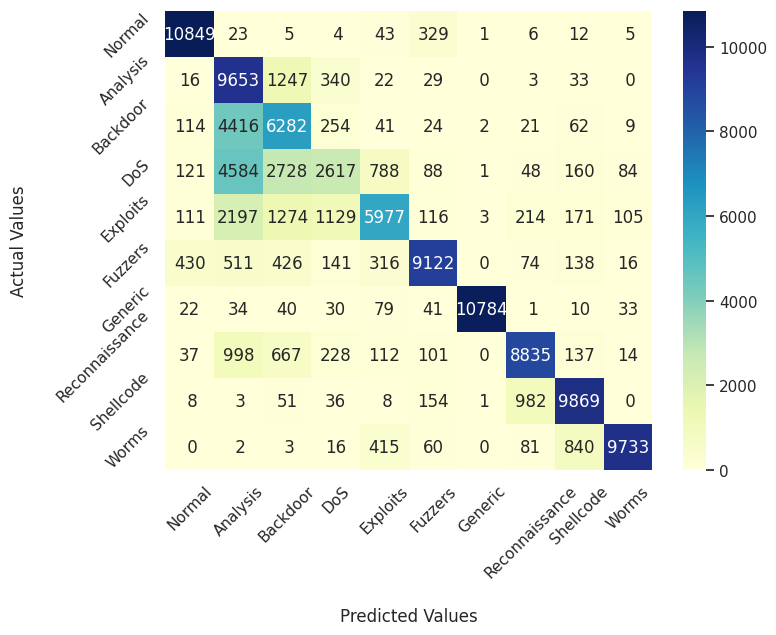

In [15]:
print("Confusion Matrix of Hybrid RF-RNN Model") 
conf_mat(np.argmax(y_test, axis=1), y_pred)

In [16]:
report = classification_report(np.argmax(y_test, axis=1), y_pred, output_dict=True)
detection_rates = {}
for cls in range(10):
    detection_rates[encoder.inverse_transform([cls])[0]] = report[str(cls)]['recall']
print("Detection rates:", detection_rates)

Detection rates: {0: 0.9620466436108894, 1: 0.8510094331305651, 2: 0.5596436525612473, 3: 0.23326499688029237, 4: 0.5290785164202886, 5: 0.8163594057633793, 6: 0.9738125338631027, 7: 0.7938718662952646, 8: 0.8881389488840893, 9: 0.872914798206278}
